In [2]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
import os
from langchain_core.tools import tool
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import Annotated, Literal, TypedDict
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import DuckDuckGoSearchRun
import requests
import sqlite3


In [3]:
load_dotenv()

True

In [4]:
llm = ChatGroq(
    model="groq/compound-mini",
    api_key=os.getenv("api_key") 
)

In [5]:
search_tool = DuckDuckGoSearchRun()

@tool
def calculator(num1: float, num2: float, operator: str)-> dict:
    """ perform basics arithmetic operations like addition , subtraction, multiplication and dvision"""
    try:
        if operator == '+':
            res = num1 + num2
        elif operator == '-':
            res = num1 - num2
        elif operator == '*':
            res = num1 * num2
        elif operator == '/':
            if num2 != 0:
                res = num1 / num2
            else:
                return {'error' : 'division cannot be done by 0'}
        else:
            return {"error" : f"Wrong operator: {operator}"}
        return {'num1' : num1, 'num2' : num2, 'operator': operator ,'result' : res}
    except Exception as e:
        return {'errors' : str(e)}
    

@tool
def Conversion(baseCurrency: str, targetCurrency : str) -> dict:
    '''Given the baseCurrency and targetCurrency, we call the api for the currency conversion factor right now between them'''
    url = f"https://v6.exchangerate-api.com/v6/{os.getenv("currency_api_key")}/latest/{baseCurrency}"
    response = requests.get(url)
    return {'result' : response.json()['conversion_rates'][targetCurrency]}


In [6]:
tools = [search_tool, calculator, Conversion]

llm_with_tools = llm.bind_tools(tools)

In [7]:
class AgentState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]

In [8]:
def llm_func(state: AgentState):
    '''llm that can answer the question or call the tool to perform an action''' 
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages' : [response]}

tool_node = ToolNode(tools = tools)

In [9]:
def which_tool(state : AgentState) -> str:
    message = state['messages'][-1]
    return message.tool_calls[0]['name']

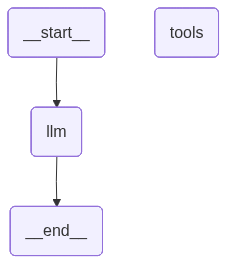

In [10]:
graph = StateGraph(AgentState)

graph.add_node("llm", llm_func)
graph.add_node("tools", tool_node)
graph.add_edge(START,"llm")
graph.add_conditional_edges("llm", which_tool)
 

workflow = graph.compile()
workflow

In [11]:
workflow.invoke({'messages' : [HumanMessage(content="What is the currency conversion factor of USD to NPR")]})

BadRequestError: Error code: 400 - {'error': {'message': '`tool calling` is not supported with this model', 'type': 'invalid_request_error', 'param': 'tool calling'}}

In [ ]:
llm_with_tools.invoke("search who is Abhishek Timsina")

BadRequestError: Error code: 400 - {'error': {'message': '`tool calling` is not supported with this model', 'type': 'invalid_request_error', 'param': 'tool calling'}}